In [7]:
import math

import numpy as np
import pytest
import torch
import torch.nn.functional as F

device = torch.device("cuda:0")

In [16]:
def test_rasterize_to_pixels():
    from gsplat.experimental.cuda import _rendering, _rendering_gsplat, rendering, quat_scale_to_covar_perci, projection, isect_tiles, isect_offset_encode, rasterize_to_pixels

    data_path = "/home/ubuntu/workdir/gsplat/DATA/new.npz"
    data = np.load(data_path)  # 3 cameras
    height, width = data["height"].item(), data["width"].item()
    viewmats = torch.from_numpy(data["viewmats"]).to(device)
    Ks = torch.from_numpy(data["Ks"]).to(device)

    means = torch.from_numpy(data["means3d"]).to(device)
    
    scales = torch.from_numpy(data["scales"]).to(device)

    quats = torch.from_numpy(data["quats"]).to(device) 
        
    opacities = torch.from_numpy(data["opacities"]).to(device) 
    opacities = opacities.squeeze()

    
    Ks = torch.tensor([[320.0, 0.0, 320.0],
                       [0.0, 320.0, 320.0],
                       [0.0, 0.0, 1.0]]).unsqueeze(0).to(device=device)  # Single camera matrix
    N = data["viewmats"].shape[0]  # Assuming viewmats is [C, 4, 4]
    Ks = Ks.repeat(N, 1, 1)  


    colors = torch.from_numpy(data["colors"]).to(device)
    colors = colors.unsqueeze(0).repeat(N, 1, 1)

    C = len(Ks)

    viewmats.requires_grad = True
    quats.requires_grad = True
    scales.requires_grad = True
    means.requires_grad = True

    render_colors, render_alphas = rendering(
        means, quats, scales, opacities, colors, viewmats, Ks, width, height
    )
    
    return render_colors, render_alphas

In [17]:
render_colors, render_alphs = test_rasterize_to_pixels()

torch.Size([2, 5000, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE SHAPE: (640, 640, 3)
TRANSPOSED: (640, 640, 3)


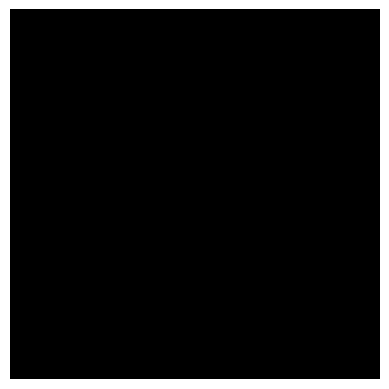

In [18]:
import matplotlib.pyplot as plt

first_image = render_colors[0].detach().cpu().numpy()

print("IMAGE SHAPE:", first_image.shape)

# Transpose the image if needed (e.g., if it is in CHW format)
first_image = np.transpose(first_image, ( 0, 1 , 2))  # Adjust transpose order based on your needs

# Print transposed shape
print("TRANSPOSED:", first_image.shape)

# Plot the transposed image
plt.imshow(first_image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()